In [1]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import numba
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif



In [2]:
# File paths for sensor data and target labels
df = 'D:/Python/Hydraulic Rig Dataset/Data/sensor_data_df.pkl'
target_df ='D:/Python/Hydraulic Rig Dataset/Data/profile_df.pkl'

# Load dataframes and drop any rows with missing values
target_data = pd.read_pickle(target_df)
data = pd.read_pickle(df)
data.dropna(inplace=True)
target_data.dropna(inplace=True)


# Inspect first few rows and target columns
print(data.head(5))
print(target_data.columns)




     CE_1    CE_2    CE_3    CE_4    CE_5    CE_6    CE_7    CE_8    CE_9  \
0  47.202  47.273  47.250  47.332  47.213  47.372  47.273  47.438  46.691   
1  29.208  28.822  28.805  28.922  28.591  28.643  28.216  27.812  27.514   
2  23.554  23.521  23.527  23.008  23.042  23.052  22.658  22.952  22.908   
3  21.540  21.419  21.565  20.857  21.052  21.039  20.926  20.912  20.989   
4  20.460  20.298  20.350  19.867  19.997  19.972  19.924  19.813  19.691   

    CE_10  ...  VS1_51  VS1_52  VS1_53  VS1_54  VS1_55  VS1_56  VS1_57  \
0  46.599  ...   0.554   0.552   0.545   0.553   0.553   0.539   0.544   
1  27.481  ...   0.555   0.547   0.548   0.544   0.536   0.542   0.540   
2  22.359  ...   0.543   0.544   0.543   0.554   0.544   0.544   0.545   
3  20.882  ...   0.549   0.538   0.553   0.543   0.553   0.555   0.544   
4  19.634  ...   0.546   0.546   0.544   0.552   0.539   0.540   0.549   

   VS1_58  VS1_59  VS1_60  
0   0.545   0.535   0.543  
1   0.533   0.531   0.534  
2   0.54

In [3]:
def ensure_60_steps(df: pd.DataFrame, n_steps: int = 60) -> pd.DataFrame:
    """
    Down/up-sample every SENSOR_<i>_<t> channel in `df` to exactly n_steps columns.
    
    - Groups columns by the prefix before the last underscore.
    - Splits each sensor’s sorted time-series into n_steps nearly-equal chunks.
    - Averages each chunk into one new column.
    
    Returns a new DataFrame with columns:
      <prefix>_1, <prefix>_2, …, <prefix>_60
    for each sensor prefix.
    """
    # 1) detect all SENSOR prefixes and their columns
    pat = re.compile(r"^(.+?)_(\d+)$")
    groups: dict[str, list[tuple[int,str]]] = {}
    for col in df.columns:
        m = pat.match(col)
        if not m:
            continue
        prefix, idx = m.groups()
        groups.setdefault(prefix, []).append((int(idx), col))
    
    # 2) build the down/up-sampled DataFrame
    out = pd.DataFrame(index=df.index)
    for prefix, idx_cols in groups.items():
        # sort by the original time index
        idx_cols_sorted = [col for _, col in sorted(idx_cols)]
        arr = df[idx_cols_sorted].to_numpy()  # shape (n_rows, orig_len)
        
        # split into n_steps groups (nearly equal sizes)
        chunks = np.array_split(arr, n_steps, axis=1)
        
        # average each chunk into one column
        for i, chunk in enumerate(chunks, start=1):
            out[f"{prefix}_{i}"] = chunk.mean(axis=1)
    
    return out

In [4]:
df_60 = ensure_60_steps(data, n_steps=60)
print(df_60.head(5))


C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{prefix}_{i}"] = chunk.mean(axis=1)
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{prefix}_{i}"] = chunk.mean(axis=1)
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

     CE_1    CE_2    CE_3    CE_4    CE_5    CE_6    CE_7    CE_8    CE_9  \
0  47.202  47.273  47.250  47.332  47.213  47.372  47.273  47.438  46.691   
1  29.208  28.822  28.805  28.922  28.591  28.643  28.216  27.812  27.514   
2  23.554  23.521  23.527  23.008  23.042  23.052  22.658  22.952  22.908   
3  21.540  21.419  21.565  20.857  21.052  21.039  20.926  20.912  20.989   
4  20.460  20.298  20.350  19.867  19.997  19.972  19.924  19.813  19.691   

    CE_10  ...  VS1_51  VS1_52  VS1_53  VS1_54  VS1_55  VS1_56  VS1_57  \
0  46.599  ...   0.554   0.552   0.545   0.553   0.553   0.539   0.544   
1  27.481  ...   0.555   0.547   0.548   0.544   0.536   0.542   0.540   
2  22.359  ...   0.543   0.544   0.543   0.554   0.544   0.544   0.545   
3  20.882  ...   0.549   0.538   0.553   0.543   0.553   0.555   0.544   
4  19.634  ...   0.546   0.546   0.544   0.552   0.539   0.540   0.549   

   VS1_58  VS1_59  VS1_60  
0   0.545   0.535   0.543  
1   0.533   0.531   0.534  
2   0.54

C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{prefix}_{i}"] = chunk.mean(axis=1)
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{prefix}_{i}"] = chunk.mean(axis=1)
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3445903259.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [5]:
nan_cols    = df_60.isna().any()
inf_cols    = np.isinf(df_60).any()
lowvar_cols = df_60.var() < 1e-6
print("NaN cols:", nan_cols.sum(),
      "Inf cols:", inf_cols.sum(),
      "Low-var :", lowvar_cols.sum())


print(df_60.describe().T)

NaN cols: 0 Inf cols: 0 Low-var : 10
         count       mean        std     min     25%     50%     75%     max
CE_1    2205.0  31.325613  11.532175  17.356  20.165  27.334  46.651  48.136
CE_2    2205.0  31.364606  11.512519  17.552  20.260  27.397  46.675  48.057
CE_3    2205.0  31.395767  11.504075  17.440  20.333  27.446  46.690  48.124
CE_4    2205.0  31.402451  11.504153  17.416  20.387  27.455  46.686  48.112
CE_5    2205.0  31.395373  11.521065  17.392  20.367  27.424  46.693  48.159
...        ...        ...        ...     ...     ...     ...     ...     ...
VS1_56  2205.0   0.575380   0.051016   0.495   0.535   0.573   0.595   0.865
VS1_57  2205.0   0.573558   0.050397   0.495   0.534   0.570   0.592   0.871
VS1_58  2205.0   0.572564   0.049652   0.499   0.534   0.569   0.591   0.867
VS1_59  2205.0   0.571495   0.049362   0.495   0.533   0.567   0.590   0.868
VS1_60  2205.0   0.574633   0.049312   0.501   0.537   0.571   0.592   0.873

[1020 rows x 8 columns]


In [6]:
# 1) Separate out your features (no Target)
X = df_60

# 2) Fit VarianceThreshold to drop *constant* columns
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)

# 3) Build the keep / drop masks
mask         = selector.get_support()    # True = kept, False = dropped
all_columns  = X.columns
kept_cols    = all_columns[mask]
dropped_cols = all_columns[~mask]

# 4) Report counts and examples
print(f"Kept {len(kept_cols)} columns, dropped {len(dropped_cols)} constant columns.")
print("Examples of dropped columns:")
for col in dropped_cols[:10]:
    print(" ", col)

# 5) Rebuild your combined DataFrame
df_60_combined = pd.concat([X[kept_cols], target_data], axis=1)




Kept 1012 columns, dropped 8 constant columns.
Examples of dropped columns:
  SE_2
  SE_3
  SE_4
  SE_5
  SE_6
  SE_7
  SE_8
  SE_9


In [7]:
X= df_60_combined.drop(columns=['Target'])
y= df_60_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def infer_sensors(df):
    pat = re.compile(r"^([A-Z]+[0-9]*)_\d+$")
    sensors = sorted({pat.match(c).group(1) for c in df.columns})
    return sensors

def augment_window_df(df, roll_k=5):
    """
    df: wide table, one 60-step window per row, columns SENSOR_1 … SENSOR_60
    returns: new dataframe with extra columns
    """
    sensors = infer_sensors(df)
    aug = df.copy()

    for s in sensors:
        cols = [c for c in df.columns if c.startswith(f"{s}_")]
        X = df[cols].to_numpy(dtype=np.float32)

        # 1) rolling mean (centered, pad edges with NaN)
        roll = pd.DataFrame(X).rolling(window=roll_k, axis=1, center=True).mean()
        roll.columns = [f"{s}_roll{roll_k}_{i+1}" for i in range(X.shape[1])]
        aug[roll.columns] = roll

        # 2) first difference
        diff = np.diff(X, axis=1, prepend=X[:, :1])
        diff_cols = [f"{s}_d1_{i+1}" for i in range(X.shape[1])]
        aug[diff_cols] = diff

        # 3) per-window mean / std  → constant channel
        m = X.mean(axis=1)
        sd = X.std(axis=1)
        aug[f"{s}_mean"] = m
        aug[f"{s}_std"]  = sd

    # 4) example cross-sensor pressure delta (PS1-PS6)
    if {"PS1_mean", "PS6_mean"}.issubset(aug.columns):
        aug["ΔPS1_PS6"] = aug["PS1_mean"] - aug["PS6_mean"]

    return aug

In [9]:
augment_data_train = augment_window_df(X_train, roll_k=5)
augment_data_test = augment_window_df(X_test, roll_k=5)
print(augment_data_train.head(5))
print(augment_data_test.head(5))

C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug[diff_cols] = diff
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug[diff_cols] = diff
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

        CE_1    CE_2    CE_3    CE_4    CE_5    CE_6    CE_7    CE_8    CE_9  \
1050  28.022  27.895  27.954  27.907  27.858  28.010  27.954  27.941  27.973   
1967  46.442  46.910  46.909  46.909  46.885  46.801  47.004  46.909  46.909   
1387  27.487  27.479  27.415  27.331  27.592  27.692  27.683  27.667  27.667   
1639  47.198  47.352  47.352  47.211  47.172  47.198  47.127  47.259  47.234   
1652  47.062  46.896  46.872  46.908  46.942  46.886  46.933  46.898  46.814   

       CE_10  ...  VS1_d1_54  VS1_d1_55  VS1_d1_56  VS1_d1_57  VS1_d1_58  \
1050  27.777  ...      0.000     -0.007     -0.003     -0.013     -0.005   
1967  46.816  ...     -0.007      0.005      0.006     -0.001      0.001   
1387  27.499  ...      0.008     -0.006     -0.005     -0.005     -0.004   
1639  46.941  ...      0.008     -0.008     -0.010     -0.003      0.006   
1652  46.852  ...      0.015     -0.004     -0.008      0.009     -0.011   

      VS1_d1_59  VS1_d1_60  VS1_mean   VS1_std    ΔPS1_PS6  
1

C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug[f"{s}_mean"] = m
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug[f"{s}_std"]  = sd
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\3369152162.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [10]:
def add_quantile_features(df, quantiles=(0.25, 0.50, 0.75, 0.95)):
    """
    For each sensor prefix in the wide df, compute the given quantiles
    across its timestep columns, and append them as new scalar columns.
    
    Input:
      df: DataFrame with columns like SENSOR_1,...,SENSOR_L
      quantiles: tuple of quantile levels to compute
    
    Returns:
      df2: original df with extra columns:
           SENSOR_q25, SENSOR_q50, SENSOR_q75, SENSOR_q95, ...
    """
    df2 = df.copy()
    # detect sensor prefixes
    pat = re.compile(r"^(.+?)_\d+$")
    sensors = sorted({pat.match(c).group(1) for c in df.columns if pat.match(c)})
    
    for s in sensors:
        cols = [c for c in df.columns if c.startswith(f"{s}_")]
        # select the subframe
        sub = df[cols]
        # compute each quantile (returns a Series indexed by df.index)
        for q in quantiles:
            name = f"{s}_q{int(q*100)}"
            df2[name] = sub.quantile(q, axis=1)
    
    return df2


X_transformed_train = add_quantile_features(X_train, quantiles=(0.25, 0.5, 0.75, 0.95))
X_transformed_test = add_quantile_features(X_test, quantiles=(0.25, 0.5, 0.75, 0.95))
print(X_transformed_train.head())
print(X_transformed_train.shape)

        CE_1    CE_2    CE_3    CE_4    CE_5    CE_6    CE_7    CE_8    CE_9  \
1050  28.022  27.895  27.954  27.907  27.858  28.010  27.954  27.941  27.973   
1967  46.442  46.910  46.909  46.909  46.885  46.801  47.004  46.909  46.909   
1387  27.487  27.479  27.415  27.331  27.592  27.692  27.683  27.667  27.667   
1639  47.198  47.352  47.352  47.211  47.172  47.198  47.127  47.259  47.234   
1652  47.062  46.896  46.872  46.908  46.942  46.886  46.933  46.898  46.814   

       CE_10  ...   TS3_q75   TS3_q95  TS4_q25  TS4_q50   TS4_q75  TS4_q95  \
1050  27.777  ...  47.85600  47.95195   41.102   41.105  41.11300  41.1170   
1967  46.816  ...  39.20100  39.34455   31.371   31.387  31.39500  31.3984   
1387  27.499  ...  46.46900  46.48460   39.687   39.691  39.75800  39.7700   
1639  46.941  ...  38.41075  38.52360   30.473   30.480  30.51475  30.5664   
1652  46.852  ...  38.46775  38.56640   30.555   30.566  30.57500  30.6522   

      VS1_q25  VS1_q50  VS1_q75  VS1_q95  
1050  0

In [11]:
# ---------------------------------------------------------------
# 1) AUGMENT sensors  (you already have augment_data)
# ---------------------------------------------------------------
features_wide_train = X_transformed_train.copy()          # <-- no Target yet
features_wide_test = X_transformed_test.copy()          # <-- no Target yet

# ---------------------------------------------------------------
# 2) RENAME / DUPLICATE so every engineered column is prefix_idx
# ---------------------------------------------------------------
def rename_engineered(col):
    if "_roll" in col:
        sensor, rest = col.split("_roll")
        win, idx = rest.split("_")
        return f"{sensor}ROLL{win}_{idx}"
    if "_d1_" in col:
        sensor, idx = col.split("_d1_")
        return f"{sensor}D1_{idx}"
    return col

features_wide_train.columns = [rename_engineered(c) for c in features_wide_train.columns]
features_wide_test.columns = [rename_engineered(c) for c in features_wide_test.columns]

scalar_cols = [c for c in features_wide_train.columns
               if not re.search(r"_(\d+)$", c)]            # no numeric suffix
for col in scalar_cols:
    for t in range(1, 61):
        features_wide_train[f"{col}_{t}"] = features_wide_train[col]
        features_wide_test[f"{col}_{t}"] = features_wide_test[col]
    features_wide_train.drop(columns=[col], inplace=True)
    features_wide_test.drop(columns=[col], inplace=True)

C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\2878411887.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_wide_train[f"{col}_{t}"] = features_wide_train[col]
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\2878411887.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_wide_test[f"{col}_{t}"] = features_wide_test[col]
C:\Users\jorda\AppData\Local\Temp\ipykernel_15008\2878411887.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [12]:
# ------------------------------------------------------------------
# 1)  base sensor list & expected length  ---------------------------
# ------------------------------------------------------------------
BASE_SENSORS = [
    "PS1","PS2","PS3","PS4","PS5","PS6",
    "EPS1","FS1","FS2",
    "TS1","TS2","TS3","TS4",
    "VS1","CE","CP","SE"
]
L = 60   # time steps per channel

# ------------------------------------------------------------------
# 2)  reshape helper (robust to extra columns)  --------------------
# ------------------------------------------------------------------
def reshape_for_minirocket(df, base_sensors, L=60, verbose=False):
    """
    df: wide DataFrame with columns like SENSOR_1 … SENSOR_60 plus extras
    returns: ndarray (n_samples, n_channels, L)
    """
    n_samples  = df.shape[0]
    n_channels = len(base_sensors)
    arr        = np.full((n_samples, n_channels, L), np.nan, dtype=np.float32)

    # regex: SENSOR_<integer>
    pat = re.compile(rf"^({'|'.join(map(re.escape, base_sensors))})_(\d+)$")

    for ch, sensor in enumerate(base_sensors):
        # collect & sort only true timestep columns
        cols = [c for c in df.columns if pat.match(c) and c.startswith(f"{sensor}_")]
        cols.sort(key=lambda s: int(s.split('_')[1]))  # numeric order

        if verbose:
            print(f"{sensor}: {len(cols)} columns")

        if cols:
            data = df[cols].to_numpy(dtype=np.float32)
            arr[:, ch, :data.shape[1]] = data[:, :L]   # right-pad with NaN

    return arr

# ------------------------------------------------------------------
# 3)  create (n_samples, n_channels, L) arrays  ---------------------
# ------------------------------------------------------------------
X_train_3d = reshape_for_minirocket(features_wide_train.loc[X_train.index], BASE_SENSORS, L)
X_test_3d  = reshape_for_minirocket(features_wide_test.loc[X_test.index],  BASE_SENSORS, L)

print("X_train_3d shape:", X_train_3d.shape)
print("X_test_3d  shape:", X_test_3d.shape)



X_train_3d shape: (1764, 17, 60)
X_test_3d  shape: (441, 17, 60)


In [13]:
# Apply MiniROCKET (multivariate version)
rocket = MiniRocketMultivariate(num_kernels=10000)
rocket.fit(X_train_3d)
X_train_transformed = rocket.transform(X_train_3d)
X_test_transformed = rocket.transform(X_test_3d)
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)

X_train_transformed shape: (1764, 9996)
X_test_transformed shape: (441, 9996)


In [14]:
# Scale the Rocket features to [0, 1] range for downstream models
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

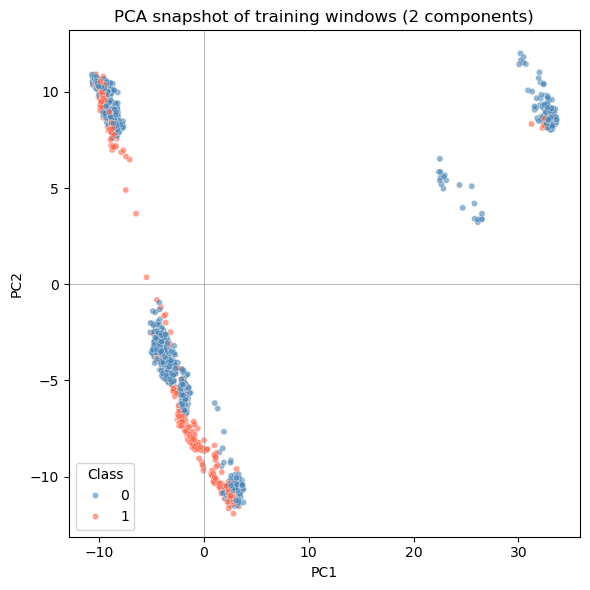

In [15]:
pca = PCA(n_components=2, random_state=1)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

import matplotlib.pyplot as plt
import seaborn as sns

# 1.  Build a dataframe for easier plotting
pca_df = (
    pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
      .assign(Target=y_train.reset_index(drop=True))
)

# 2.  Scatter-plot
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Target",
    palette={0: "steelblue", 1: "tomato"},
    alpha=0.6, s=20
)
plt.axhline(0, lw=.4, color="grey"); plt.axvline(0, lw=.4, color="grey")
plt.title("PCA snapshot of training windows (2 components)")
plt.legend(title="Class", loc="best")
plt.tight_layout()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1764 samples in 0.013s...
[t-SNE] Computed neighbors for 1764 samples in 0.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1764
[t-SNE] Computed conditional probabilities for sample 1764 / 1764
[t-SNE] Mean sigma: 3.339361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.140045
[t-SNE] KL divergence after 2000 iterations: 0.313709


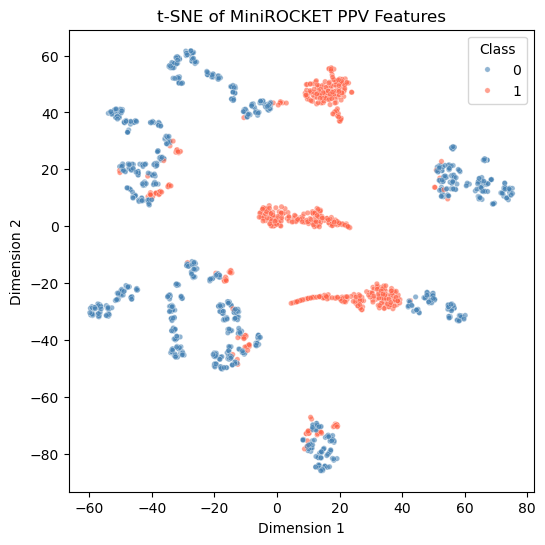

In [19]:

from sklearn.manifold import TSNE

# 1) Determine sample size safely
n_rows = X_train_scaled.shape[0]
sample_size = min(5000, n_rows)       # if you have <5000 windows, just use them all

# 2) Subsample (without replacement)
rng = np.random.RandomState(0)
idx = rng.choice(n_rows, size=sample_size, replace=False)
X_sub = X_train_scaled[idx]
y_sub = y_train.values[idx]

# 3) Run t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=2000,
    init="pca",
    random_state=0,
    verbose=1
)
X_emb = tsne.fit_transform(X_sub)

# 4) Plot
df_emb = pd.DataFrame(X_emb, columns=["Dim1","Dim2"])
df_emb["Class"] = y_sub

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df_emb,
    x="Dim1", y="Dim2",
    hue="Class",
    palette={0:"steelblue",1:"tomato"},
    alpha=0.6, s=15
)
plt.title("t-SNE of MiniROCKET PPV Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Class")
plt.show()


         total  faults    purity
cluster                         
0          255     168  0.658824
1           10       0  0.000000
2          187       8  0.042781
3          171      22  0.128655
4          174       7  0.040230
5          133      31  0.233083
6          146     146  1.000000
7          166     166  1.000000
8           98       0  0.000000
9           92       0  0.000000
10         253      42  0.166008
11          69      19  0.275362
12          10       0  0.000000


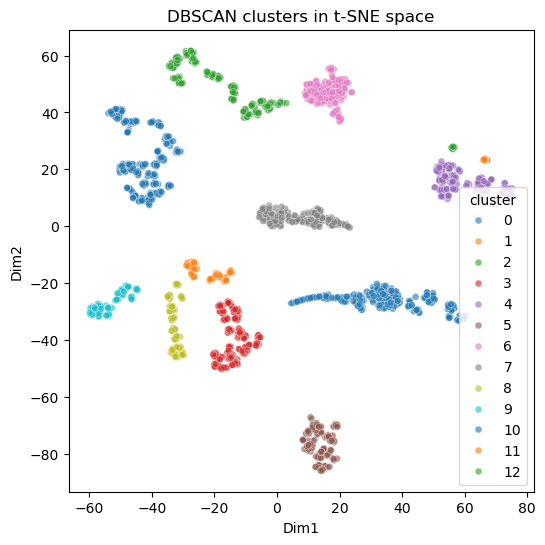

Decision‐tree rules for cluster assignment:

|--- Dim1 <= -34.20
|   |--- Dim2 <= -6.69
|   |   |--- Dim1 <= -39.77
|   |   |   |--- class: 9
|   |   |--- Dim1 >  -39.77
|   |   |   |--- class: 8
|   |--- Dim2 >  -6.69
|   |   |--- Dim2 <= 48.67
|   |   |   |--- class: 10
|   |   |--- Dim2 >  48.67
|   |   |   |--- class: 2
|--- Dim1 >  -34.20
|   |--- Dim2 <= -19.80
|   |   |--- Dim1 <= -0.39
|   |   |   |--- class: 3
|   |   |--- Dim1 >  -0.39
|   |   |   |--- class: 0
|   |--- Dim2 >  -19.80
|   |   |--- Dim2 <= 33.40
|   |   |   |--- class: 4
|   |   |--- Dim2 >  33.40
|   |   |   |--- class: 2



In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier, export_text
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Cluster in t-SNE space ------------------------------------------------
# X_emb: array shape (n_sub,2), df_emb has Dim1, Dim2, Class
db = DBSCAN(eps=5, min_samples=10).fit(X_emb)
df_emb["cluster"] = db.labels_  # -1 = noise

# 2) Profile clusters for class purity ------------------------------------
cluster_summary = (
    df_emb.groupby("cluster")["Class"]
          .agg(total="size", faults=lambda s: s.sum())
          .assign(purity=lambda d: d["faults"]/d["total"])
)
print(cluster_summary)

# 3) Plot clusters --------------------------------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_emb, x="Dim1", y="Dim2",
                hue="cluster", palette="tab10", s=25, alpha=0.6)
plt.title("DBSCAN clusters in t-SNE space")
plt.show()

# 4) Learn simple rules via a small decision tree ------------------------
# only fit on non-noise points
mask = df_emb["cluster"]>=0
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_emb[mask], df_emb.loc[mask,"cluster"])

rules = export_text(clf, feature_names=["Dim1","Dim2"])
print("Decision‐tree rules for cluster assignment:\n")
print(rules)



X_train_3d shape: (1764, 17, 60)
X_test_3d  shape: (441, 17, 60)


In [ ]:
# Save the processed datasets and labels to disk for later use
X_train_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/X_train_pickled.pkl'
X_test_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/X_test_pickled.pkl'
y_train_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/y_train_pickled.pkl'
y_test_pickled = 'D:/Python/Hydraulic Rig Dataset/Data/y_test_pickled.pkl'

X_train_transformed.to_pickle(X_train_pickled)  # save train features
X_test_transformed.to_pickle(X_test_pickled)     # save test features
y_train.to_pickle(y_train_pickled)               # save train labels
y_test.to_pickle(y_test_pickled)     # save test labels
